# Desafío Cargo Data Scientist - Carozzi

* Este notebook contiene:
    * Exploración inicial de los datos de ventas, promociones, valor del petróleo y tiendas.
    * Análisis de tendencias y correlaciones.
    * Feature Engineering.
    * Modelamiento.
    * Proyección de ventas.

## Main imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Añadir src al path
import sys, os
from pathlib import Path

SRC = str(Path.cwd().parent / 'src')
if SRC not in sys.path:
    sys.path.insert(0, SRC)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# import plotly.graph_objects as go

In [172]:
from params import Params
# from data_preprocessing import load_data, preprocess_data
par = Params()

## Carga y revisión de los datos

### Data de ventas

In [ ]:
df_data = pd.read_csv(par.DATA_PATH, parse_dates=['date'])

In [6]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [7]:
df_data.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [8]:
df_data.sample(10)

,id,date,store_nbr,family,sales,onpromotion
2029730,2029730,2016-02-17,1,SEAFOOD,38.805,0
153275,153275,2013-03-28,1,MAGAZINES,0.000,0
2989095,2989095,2017-08-09,28,LINGERIE,5.000,0
1862638,1862638,2015-11-14,21,LADIESWEAR,4.000,0
1398300,1398300,2015-02-26,42,MEATS,0.000,0
22312,22312,2013-01-13,35,BOOKS,0.000,0
2026089,2026089,2016-02-14,8,LINGERIE,8.000,0
1233061,1233061,2014-11-24,7,HOME AND KITCHEN II,17.000,0
2020051,2020051,2016-02-11,38,"LIQUOR,WINE,BEER",63.000,0
2744958,2744958,2017-03-25,28,HOME CARE,315.000,10


In [9]:
print(np.divide(df_data.shape[0], df_data['id'].nunique()))

1.0


In [10]:
df_data.describe()

,id,date,store_nbr,sales,onpromotion
count,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,3.577757e+02,2.602770e+00
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,1.247170e+05,7.410000e+02
std,8.662819e+05,NaN,1.558579e+01,1.101998e+03,1.221888e+01


In [11]:
df_data[df_data['sales'] <= 0].shape[0], df_data.shape[0], np.divide(df_data[df_data['sales'] <= 0].shape[0], df_data.shape[0])

(939130, 3000888, np.float64(0.3129506999261552))

* Hasta acá podemos ver valores 0 para ventas. Un poco más del 31% de los datos. Se analizará filtrar esta data considerando el desempeño del modelo.
* Tambien se observan valores `>1` en `onpromotion`.
* Se indica la tienda en todos los registros, desde `1` hasta `54`.

In [12]:
df_data = df_data[df_data['sales'] > 0].copy()

<Axes: xlabel='store_nbr'>

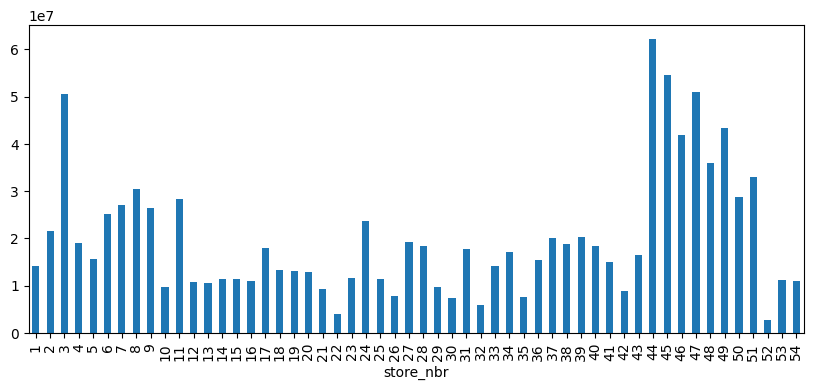

In [13]:
# ventas por tienda
df_data.groupby(['store_nbr'])['sales'].sum().sort_index().plot(kind='bar', figsize=(10, 4))

Text(0.5, 1.0, 'Total de ventas por tienda')

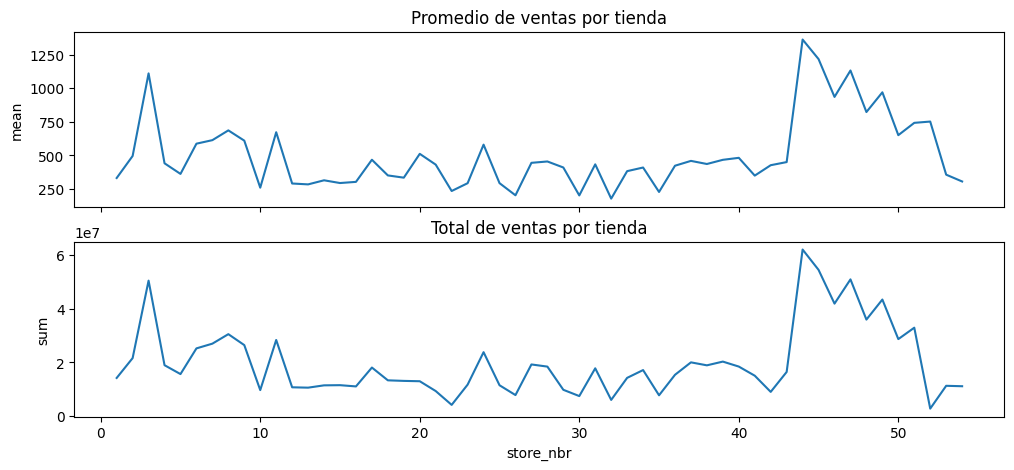

In [14]:
df_store_nbr = df_data.groupby('store_nbr')['sales'].agg(['mean', 'sum', 'count']).sort_values(by='sum', ascending=False).copy()

fig, ax = plt.subplots(2,1,figsize=(12,5), sharex=True)
ax = ax.flat

sns.lineplot(data=df_store_nbr, x=df_store_nbr.index, y='mean', ax=ax[0])
sns.lineplot(data=df_store_nbr, x=df_store_nbr.index, y='sum', ax=ax[1])

ax[0].set_title('Promedio de ventas por tienda')
ax[1].set_title('Total de ventas por tienda')

Text(0.5, 1.0, 'Total de ventas por familia')

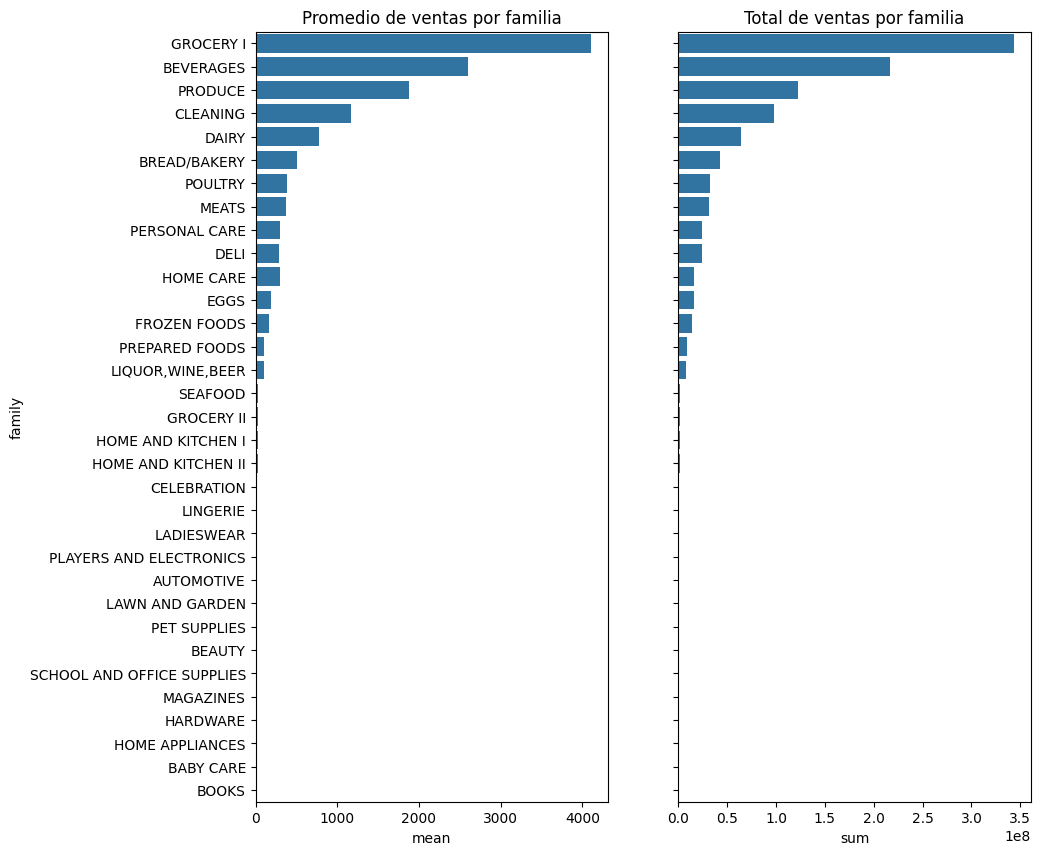

In [15]:
df_family = df_data.groupby('family')['sales'].agg(['mean', 'sum', 'count']).sort_values(by='sum', ascending=False).copy()

fig, ax = plt.subplots(1,2,figsize=(10,10), sharey=True)
ax = ax.flat

sns.barplot(data=df_family, y=df_family.index, x='mean', ax=ax[0])
sns.barplot(data=df_family, y=df_family.index, x='sum', ax=ax[1])

ax[0].set_title('Promedio de ventas por familia')
ax[1].set_title('Total de ventas por familia')

* Acá se observan familias con ventas muy bajas. Esto podría afectar el desempeño del modelo. Por lo que se analizará su exclusión para este análisis.

In [16]:
df_family.sort_values(by='sum', ascending=True).head(10)

,mean,sum,count
family,,,
BOOKS,2.325027,6438.0,2769
BABY CARE,1.883268,10051.0,5337
HOME APPLIANCES,1.727473,41601.0,24082
HARDWARE,2.182359,103470.0,47412
MAGAZINES,6.739512,266359.0,39522
SCHOOL AND OFFICE SUPPLIES,11.427189,269316.0,23568
BEAUTY,5.040471,337893.0,67036
PET SUPPLIES,8.640062,356584.0,41271
LAWN AND GARDEN,11.341585,548842.0,48392


In [17]:
date_list = pd.date_range(start=df_data['date'].min(), end=df_data['date'].max()).tolist()
print(len(date_list))

1688


In [18]:
data_date_list = list(df_data['date'].unique())
print(len(data_date_list))

1684


In [19]:
missing_dates_list = [d for d in date_list if d not in data_date_list]
print(len(missing_dates_list))

4


In [20]:
# no hay ventas en navidad
missing_dates_list

[Timestamp('2013-12-25 00:00:00'),
 Timestamp('2014-12-25 00:00:00'),
 Timestamp('2015-12-25 00:00:00'),
 Timestamp('2016-12-25 00:00:00')]

* Acá se observa que no existen registros de ventas para los días de Navidad en cada año.

In [21]:
df_data['year'] = df_data['date'].dt.year
df_data['year_month'] = df_data['date'].dt.to_period('M')
df_data['year_week'] = df_data['date'].dt.isocalendar().year.astype(str) + '-' + df_data['date'].dt.isocalendar().week.astype(str)

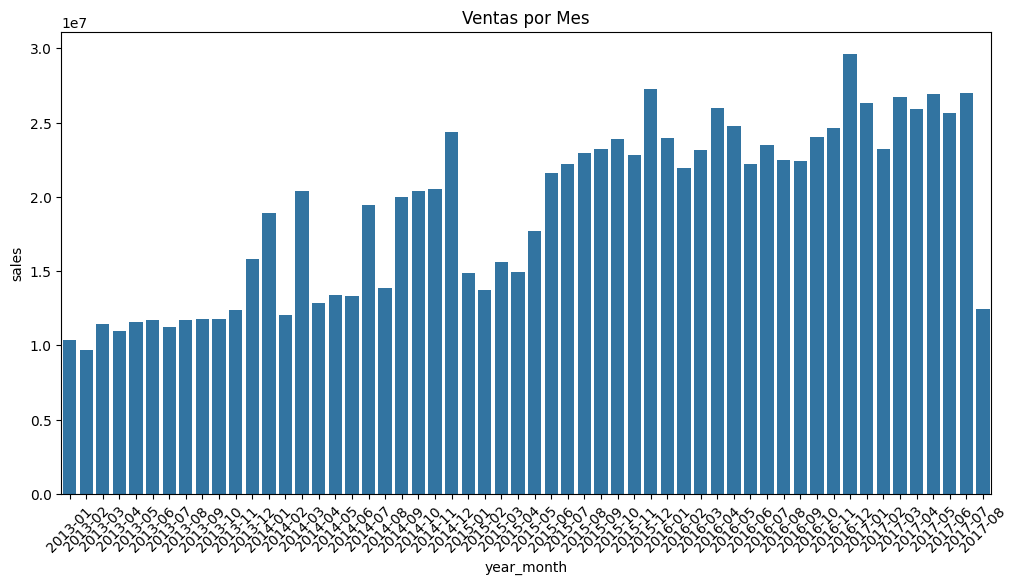

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='year_month', y='sales', data=df_data.groupby('year_month').agg({'sales': 'sum'}).reset_index(), ax=ax)
ax.set_title('Ventas por Mes')
ax.tick_params(axis='x', rotation=45)

* Acá ya se puede observar una tendencia al alza en las ventas.

In [23]:
df_data[df_data['onpromotion'] > 0].sort_values(by='onpromotion', ascending=False).head(10)

,id,date,store_nbr,family,sales,onpromotion,year,year_month,year_week
2216622,2216622,2016-05-31,53,GROCERY I,7517.0,741,2016,2016-05,2016-22
2200584,2200584,2016-05-22,53,GROCERY I,6044.0,726,2016,2016-05,2016-20
2211276,2211276,2016-05-28,53,GROCERY I,5846.0,722,2016,2016-05,2016-21
2188110,2188110,2016-05-15,53,GROCERY I,6154.0,720,2016,2016-05,2016-19
2213058,2213058,2016-05-29,53,GROCERY I,6681.0,719,2016,2016-05,2016-21
2163162,2163162,2016-05-01,53,GROCERY I,6712.0,718,2016,2016-05,2016-17
2186328,2186328,2016-05-14,53,GROCERY I,6262.0,717,2016,2016-05,2016-19
2209494,2209494,2016-05-27,53,GROCERY I,5601.0,716,2016,2016-05,2016-21
2198802,2198802,2016-05-21,53,GROCERY I,5800.0,716,2016,2016-05,2016-20
2161380,2161380,2016-04-30,53,GROCERY I,5948.0,710,2016,2016-04,2016-17


<Axes: xlabel='sales'>

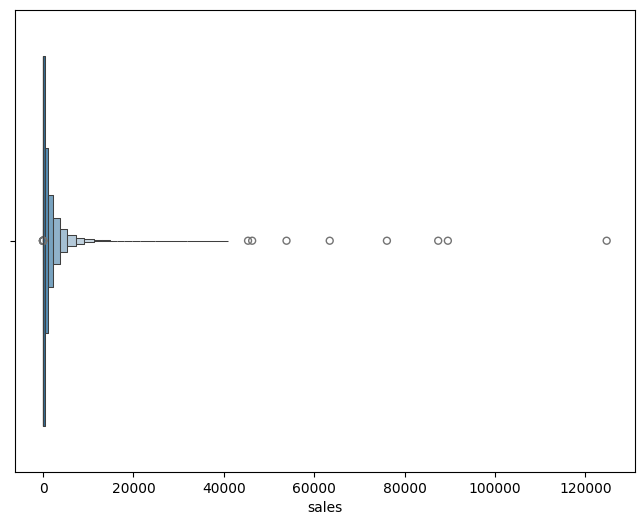

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxenplot(data=df_data, x='sales', ax=ax)

* Se puede apreciar que las ventas tienen una tendencia hacia el `0` con la presencia de ventas que podrían ser anómalas y ser consideradas como outliers.

<Axes: xlabel='sales'>

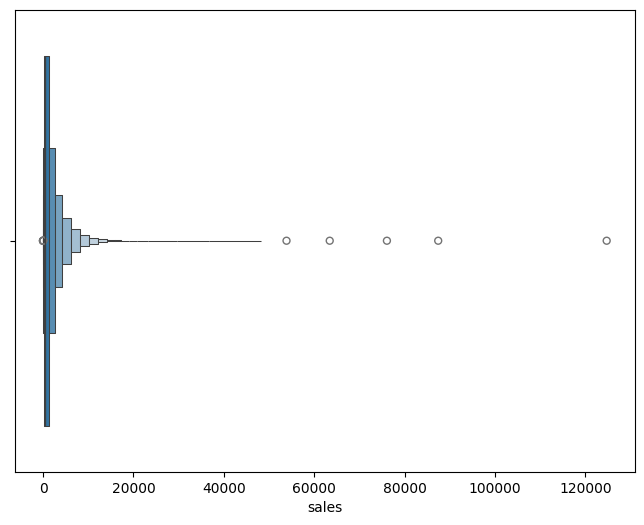

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxenplot(data=df_data[df_data['onpromotion'] > 0], x='sales', ax=ax)

In [26]:
print(np.divide(df_data[df_data['onpromotion']>0].shape[0], df_data['onpromotion'].shape[0]))

0.29650036522230055


In [27]:
df_data['onpromotion_flag'] = np.where(df_data['onpromotion'] > 0, 1, 0)

<Axes: xlabel='onpromotion_flag'>

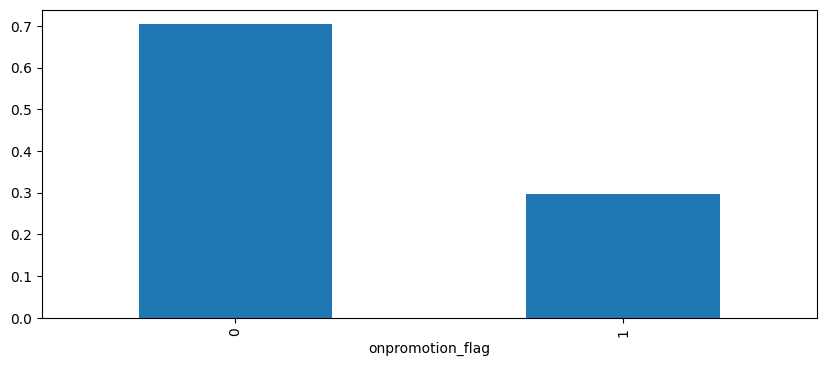

In [28]:
df_data['onpromotion_flag'].value_counts('%').sort_index().plot(kind='bar', figsize=(10, 4))


In [29]:
df_data['onpromotion_flag'].value_counts('%')

onpromotion_flag
0    0.7035
1    0.2965
Name: proportion, dtype: float64

* Un 20% de las ventas tienen al menos un producto con promoción activa.

#### Outliers en ventas

In [30]:
import numpy as np

Q1 = df_data['sales'].quantile(0.25)
Q3 = df_data['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_data['sales_outlier_iqr'] = ((df_data['sales'] < lower_bound) | (df_data['sales'] > upper_bound)).astype(int)

print("Outliers detectados (IQR):", df_data['sales_outlier_iqr'].sum())
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)


Outliers detectados (IQR): 278184
Lower bound: -559.5
Upper bound: 956.5


In [31]:
np.divide(df_data['sales_outlier_iqr'].sum(), df_data['sales'].count())

np.float64(0.1349256314271607)

In [32]:
# Rolling IQR / Median Absolute Deviation
window = 28  # días (aprox. 4 semanas)
rolling_median = df_data['sales'].rolling(window=window, center=True).median()
mad = df_data['sales'].rolling(window=window, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))))

threshold = 3  # z-score
df_data['sales_outlier_mad_28'] = ((df_data['sales'] - rolling_median).abs() > threshold * mad).astype(int)

print("Outliers detectados (Rolling MAD):", df_data['sales_outlier_mad_28'].sum())

Outliers detectados (Rolling MAD): 590726


In [33]:
np.divide(df_data['sales_outlier_mad_28'].sum(), df_data['sales'].count())

np.float64(0.2865156822478681)

In [34]:
# Rolling IQR / Median Absolute Deviation
window = 7 # días (aprox. 1 semana)
rolling_median = df_data['sales'].rolling(window=window, center=True).median()
mad = df_data['sales'].rolling(window=window, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))))

threshold = 3  # z-score
df_data['sales_outlier_mad_7'] = ((df_data['sales'] - rolling_median).abs() > threshold * mad).astype(int)

print("Outliers detectados (Rolling MAD):", df_data['sales_outlier_mad_7'].sum())

Outliers detectados (Rolling MAD): 464805


In [35]:
np.divide(df_data['sales_outlier_mad_7'].sum(), df_data['sales'].count())

np.float64(0.22544110414510335)

* Utilizando el médoto IQR para detectar outliers en ventas vemos lo siguiente:
    * Cerca del 14% de las ventas se consdieran outliers analizando toda la historia.
    * Cerca del 28% de las ventas se consideran outliers utilizando una ventana móvil de 28 días (mensual).
    * Considerando una ventana móvil de 7 días (semanal) la cantidad de outliers es de 23%.

* Se considerará IQR general como proxy para outliers.

### Data de tiendas

In [ ]:
df_stores = pd.read_csv(par.STORES_PATH)

In [37]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [38]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [39]:
df_stores['store_nbr'].nunique()

54

In [40]:
df_stores['store_nbr'].shape[0]

54

<Axes: xlabel='state'>

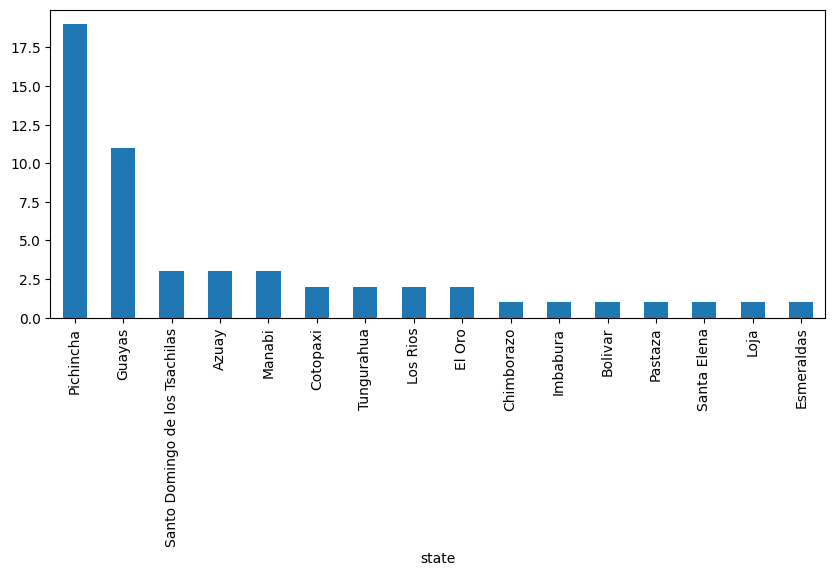

In [41]:
df_stores['state'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 4))

In [42]:
df_stores['state'].value_counts()

state
Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: count, dtype: int64

<Axes: xlabel='city'>

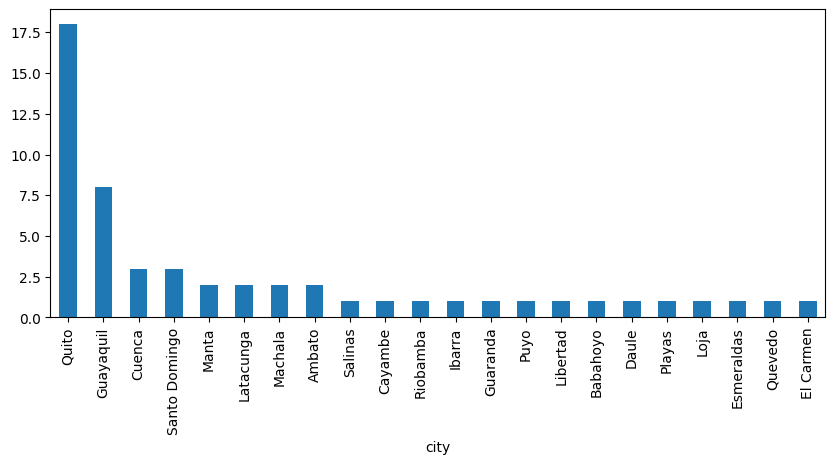

In [43]:
df_stores['city'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(10, 4))

In [44]:
df_stores['city'].value_counts()

city
Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: count, dtype: int64

In [45]:
df_stores.groupby(['state', 'city']).size().sort_values(ascending=False)

state                           city         
Pichincha                       Quito            18
Guayas                          Guayaquil         8
Azuay                           Cuenca            3
Santo Domingo de los Tsachilas  Santo Domingo     3
Manabi                          Manta             2
Tungurahua                      Ambato            2
El Oro                          Machala           2
Cotopaxi                        Latacunga         2
Guayas                          Daule             1
Esmeraldas                      Esmeraldas        1
Guayas                          Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Bolivar                         Guaranda          1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
Pastaza                         Puyo              1
Pichincha         

<Axes: xlabel='state,city'>

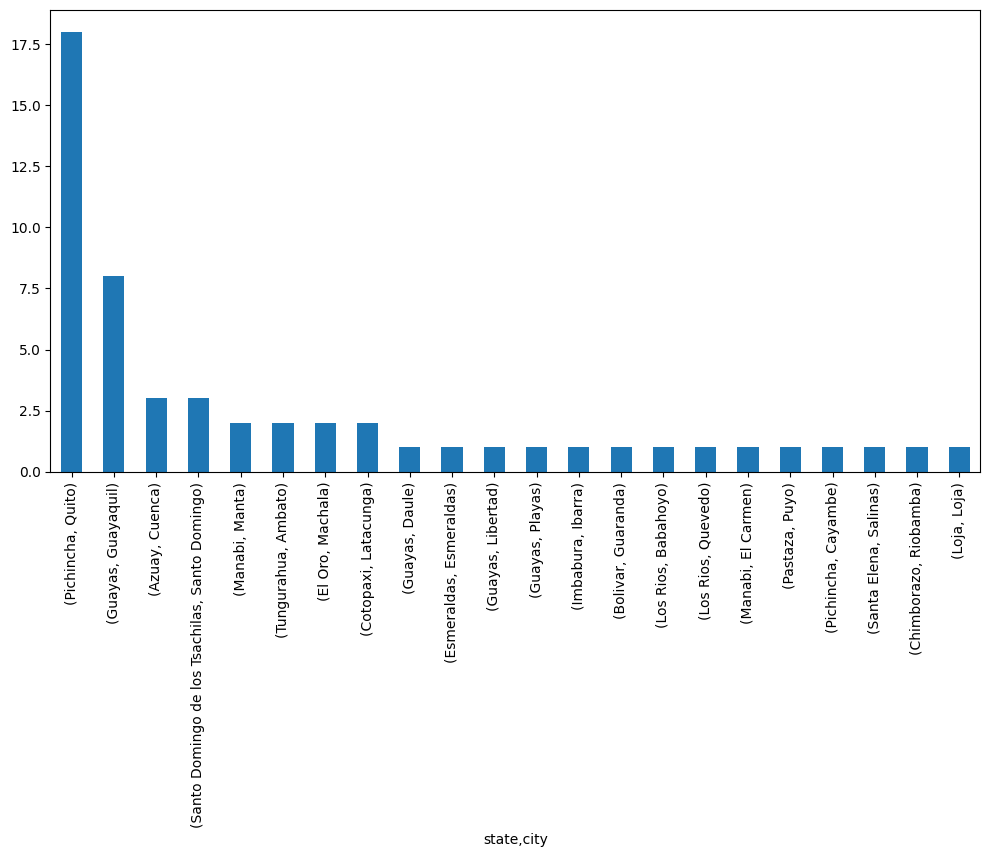

In [46]:
df_stores.groupby(['state', 'city']).size().sort_values(ascending=False).plot(kind='bar', figsize=(12,6))

In [47]:
df_stores.groupby(['state', 'city']).size().sort_values(ascending=False)

state                           city         
Pichincha                       Quito            18
Guayas                          Guayaquil         8
Azuay                           Cuenca            3
Santo Domingo de los Tsachilas  Santo Domingo     3
Manabi                          Manta             2
Tungurahua                      Ambato            2
El Oro                          Machala           2
Cotopaxi                        Latacunga         2
Guayas                          Daule             1
Esmeraldas                      Esmeraldas        1
Guayas                          Libertad          1
                                Playas            1
Imbabura                        Ibarra            1
Bolivar                         Guaranda          1
Los Rios                        Babahoyo          1
                                Quevedo           1
Manabi                          El Carmen         1
Pastaza                         Puyo              1
Pichincha         

* Las ciudades con mayor numero de tiendas son Quito y Guayaquil.
* Siguen con 3 tiendas Cuenca y Santo Domingo.
* Con más de una tienda tenemos a Manta, Ambato, Machala y Latacunga.
* Las demás ciudades tiene solo una tienda.

<Axes: xlabel='type'>

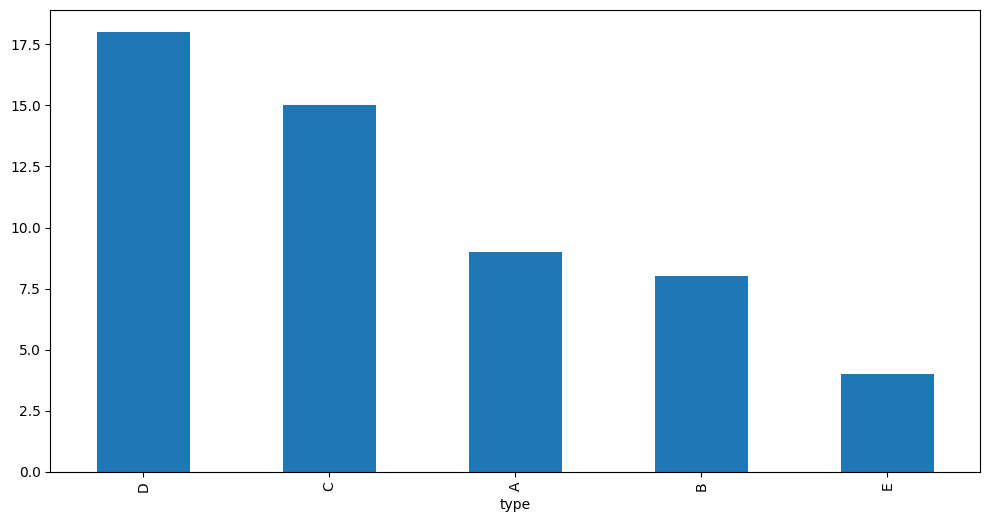

In [48]:
df_stores['type'].value_counts().plot(kind='bar', figsize=(12,6))

In [49]:
df_stores['type'].value_counts()

type
D    18
C    15
A     9
B     8
E     4
Name: count, dtype: int64

* El tipo de sala de supermercado más común de tiendas es el `D` seguido por `C` con 15 tiendas o más.
* Luego tenemos `A` y `B` con 8 y 9 tiendas.
* Finalmente `E` con solo 4 tiendas.

<Axes: xlabel='cluster'>

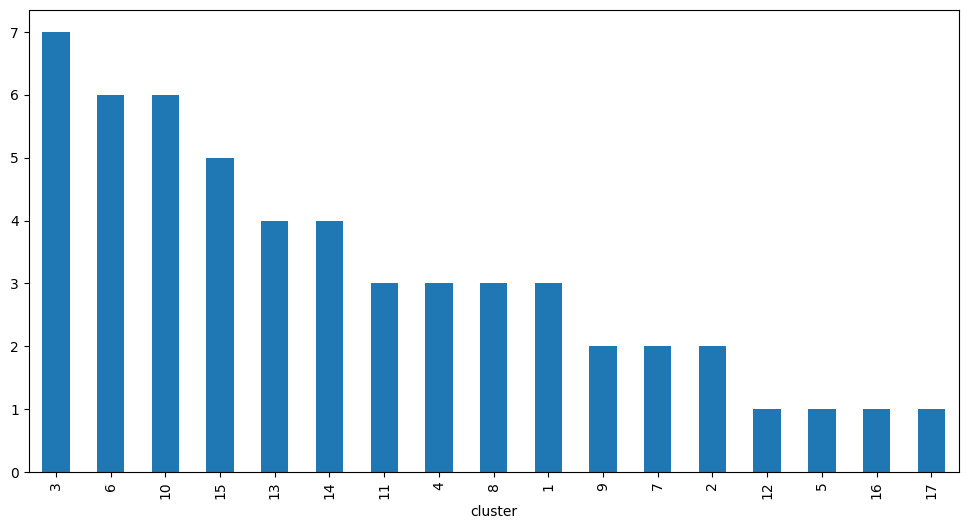

In [50]:
df_stores['cluster'].value_counts().plot(kind='bar', figsize=(12,6))

In [51]:
df_stores.groupby(['type', 'cluster']).agg({'store_nbr': 'count'}).reset_index()

,type,cluster,store_nbr
0,A,5,1
1,A,11,3
2,A,14,4
3,A,17,1
4,B,6,6
5,B,10,1
6,B,16,1
7,C,3,7
8,C,7,2
9,C,12,1


<Axes: xlabel='type', ylabel='store_nbr'>

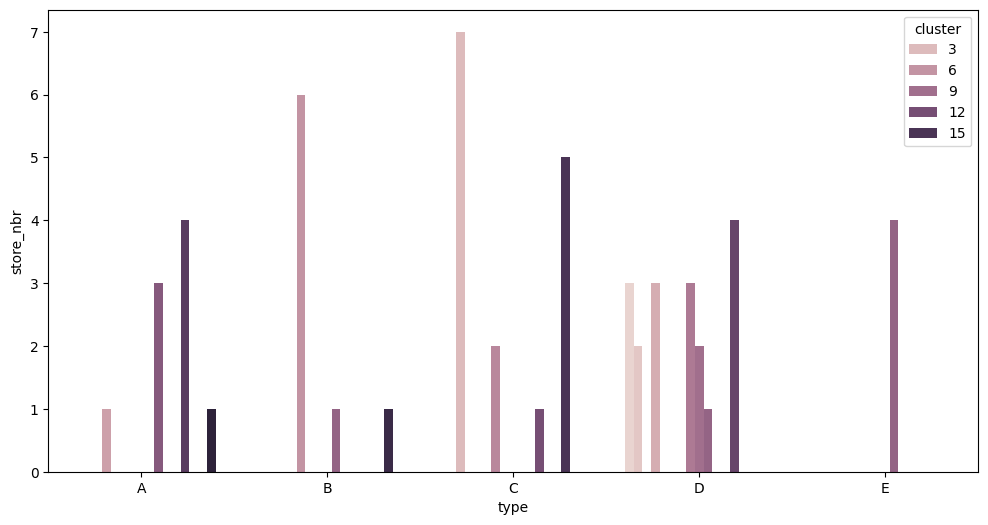

In [52]:
fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df_stores.groupby(['type', 'cluster']).agg({'store_nbr': 'count'}).reset_index(), x='type', y='store_nbr', hue='cluster', ax=ax)


### Precio diario del petróleo

In [ ]:
df_oil = pd.read_csv(par.OIL_PATH, parse_dates=['date'])

In [54]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


<Axes: xlabel='date'>

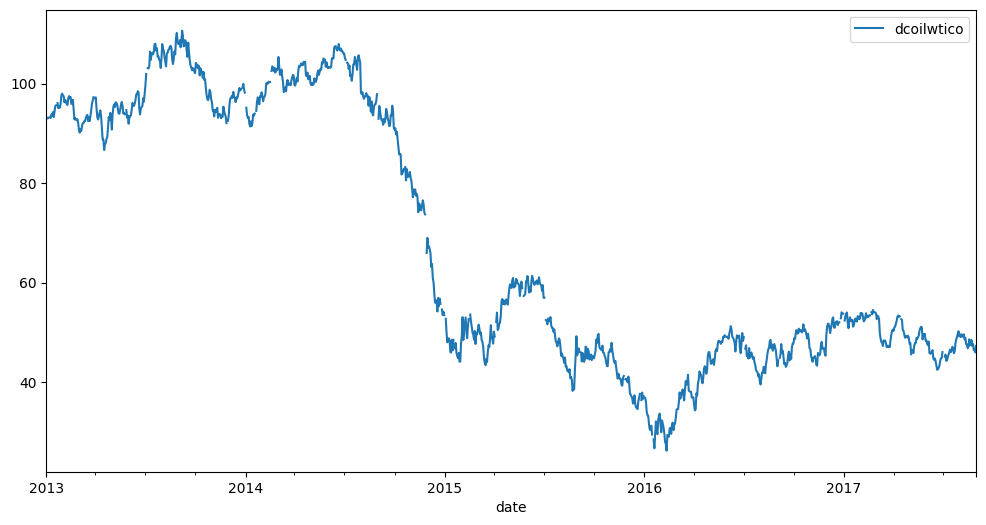

In [55]:
df_oil.plot(x='date', y='dcoilwtico', figsize=(12,6))

* Para las fechas sin datos, se utilizará el valor anterior.

## Merge de datos

In [56]:
df_sales = df_data.merge(df_stores, on='store_nbr', how='left').copy()

In [57]:
df_sales = df_sales.merge(df_oil, on='date', how='left').copy()

In [58]:
df_sales.isna().sum()

id                           0
date                         0
store_nbr                    0
family                       0
sales                        0
onpromotion                  0
year                         0
year_month                   0
year_week                    0
onpromotion_flag             0
sales_outlier_iqr            0
sales_outlier_mad_28         0
sales_outlier_mad_7          0
city                         0
state                        0
type                         0
cluster                      0
dcoilwtico              637394
dtype: int64

Text(0, 0.5, 'Ventas Promedio')

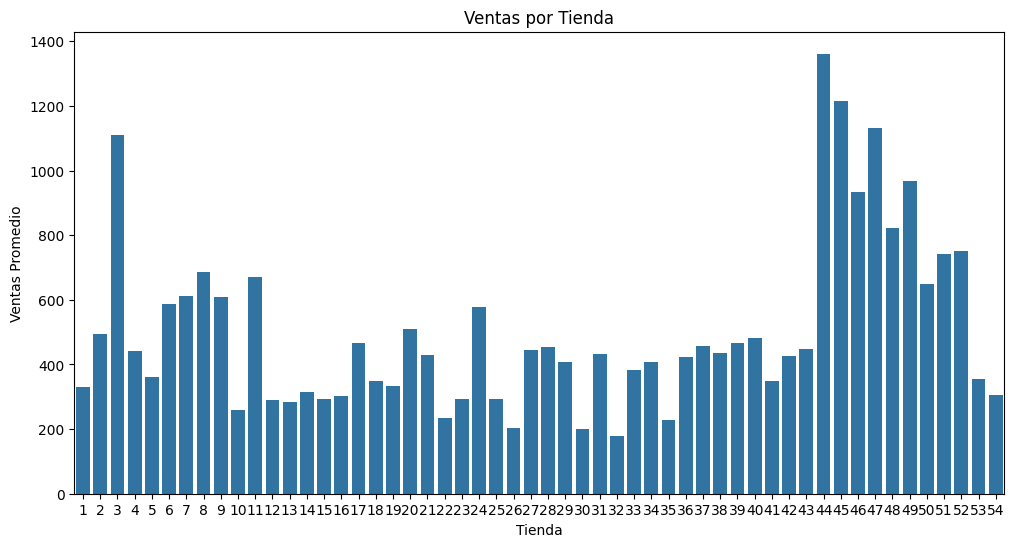

In [59]:
sales_store = df_sales.groupby('store_nbr')['sales'].mean().sort_values(ascending=False).copy()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=sales_store.index, y=sales_store.values, ax=ax)
ax.set_title('Ventas por Tienda')
ax.set_xlabel('Tienda')
ax.set_ylabel('Ventas Promedio')

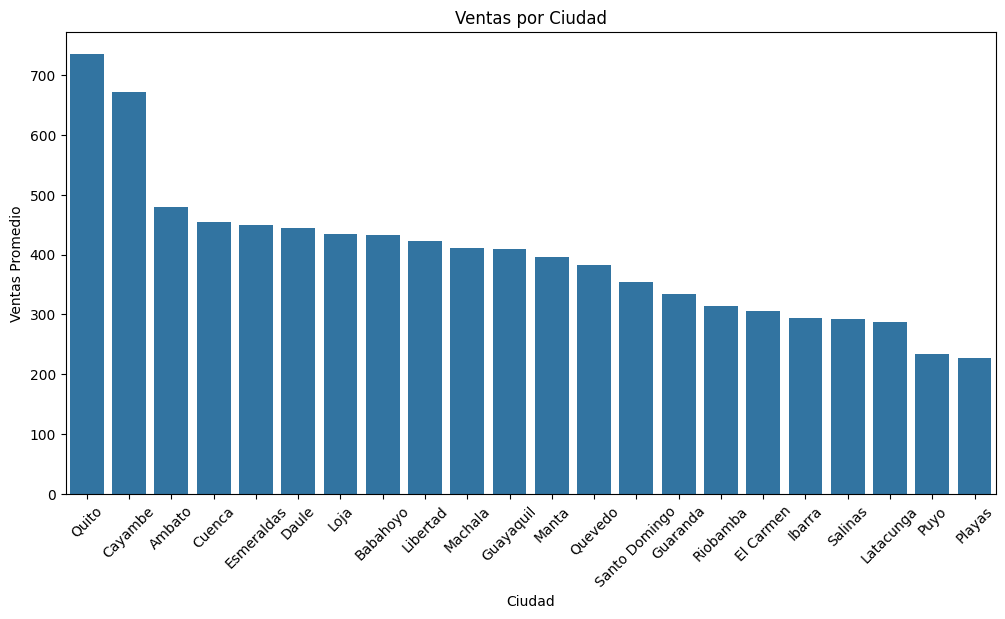

In [60]:
sales_city = df_sales.groupby('city')['sales'].mean().sort_values(ascending=False).copy()

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=sales_city.index, y=sales_city.values, ax=ax)
ax.set_title('Ventas por Ciudad')
ax.set_xlabel('Ciudad')
ax.set_ylabel('Ventas Promedio')
ax.tick_params(axis='x', rotation=45)

* En promedio Quito y Cayambe son las ciudades con mayor promedio de ventas.

## Feature Engineering

In [103]:
# variables de tiempo
df_sales['year'] = df_sales['date'].dt.year
df_sales['month'] = df_sales['date'].dt.month
df_sales['week'] = df_sales['date'].dt.isocalendar().week.astype(int)
df_sales['dayofweek'] = df_sales['date'].dt.dayofweek
df_sales['is_weekend'] = df_sales['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df_sales['year_week'] = df_sales['date'].dt.strftime('%Y-%V')

# promociones
df_sales['onpromotion_flag'] = df_sales['onpromotion'].apply(lambda x: 1 if x>0 else 0)

# precio petroleo
df_sales['dcoilwtico'] = df_sales['dcoilwtico'].ffill()

# ventas semanales
df_sales['weekly_sales'] = df_sales['sales'].rolling(window=7).sum()

# ventas semanales agg
weekly_sales = df_sales.groupby(['store_nbr', 'family', 'type', 'cluster', 'year', 'week', 'year_week']).agg(
    sales=('sales', 'sum'), 
    onpromotion_flag=('onpromotion_flag', 'sum'), 
    dcoilwtico=('dcoilwtico', 'mean'),
    sales_week_avg=('sales', 'mean')
).reset_index().copy()

# onpromotion_flag
weekly_sales['onpromotion_flag'] = weekly_sales['onpromotion_flag'].apply(lambda x: 1 if x > 0 else 0)

# ventas pasadas
weekly_sales['sales_lag_1'] = weekly_sales.groupby('store_nbr')['sales'].shift(1)
weekly_sales['sales_lag_2'] = weekly_sales.groupby('store_nbr')['sales'].shift(2)
weekly_sales['sales_lag_4'] = weekly_sales.groupby('store_nbr')['sales'].shift(4)

# medias moviles
weekly_sales['sales_ma_1'] = weekly_sales['sales'].rolling(window=1).mean()
weekly_sales['sales_ma_2'] = weekly_sales['sales'].rolling(window=2).mean()
weekly_sales['sales_ma_3'] = weekly_sales['sales'].rolling(window=3).mean()
weekly_sales['sales_ma_4'] = weekly_sales['sales'].rolling(window=4).mean()

# relleno medias moviles y pasadas sin datos
weekly_sales.fillna({'sales_lag_1': 0, 'sales_lag_2': 0, 'sales_lag_4': 0, 'sales_ma_1': 0, 'sales_ma_2': 0, 'sales_ma_3': 0, 'sales_ma_4': 0}, inplace=True)

# ventas diarias agg
daily_sales = df_sales.groupby(['date', 'store_nbr', 'family', 'type', 'cluster']).agg(
    sales=('sales', 'sum'), 
    onpromotion_flag=('onpromotion_flag', 'sum'), 
    dcoilwtico=('dcoilwtico', 'mean')
).reset_index()
daily_sales['dcoilwtico'] = daily_sales['dcoilwtico'].ffill().bfill()

# onpromotion_flag
daily_sales['onpromotion_flag'] = daily_sales['onpromotion_flag'].apply(lambda x: 1 if x > 0 else 0)

# ventas pasadas
daily_sales['sales_lag_1'] = daily_sales.groupby('store_nbr')['sales'].shift(1)
daily_sales['sales_lag_2'] = daily_sales.groupby('store_nbr')['sales'].shift(2)
daily_sales['sales_lag_3'] = daily_sales.groupby('store_nbr')['sales'].shift(3)
daily_sales['sales_lag_4'] = daily_sales.groupby('store_nbr')['sales'].shift(4)
daily_sales['sales_lag_5'] = daily_sales.groupby('store_nbr')['sales'].shift(5)
daily_sales['sales_lag_6'] = daily_sales.groupby('store_nbr')['sales'].shift(6)
daily_sales['sales_lag_7'] = daily_sales.groupby('store_nbr')['sales'].shift(7)
daily_sales['sales_lag_8'] = daily_sales.groupby('store_nbr')['sales'].shift(8)

# medias moviles
daily_sales['sales_ma_1'] = daily_sales['sales'].rolling(window=1).mean()
daily_sales['sales_ma_2'] = daily_sales['sales'].rolling(window=2).mean()
daily_sales['sales_ma_3'] = daily_sales['sales'].rolling(window=3).mean()
daily_sales['sales_ma_4'] = daily_sales['sales'].rolling(window=4).mean()
daily_sales['sales_ma_5'] = daily_sales['sales'].rolling(window=5).mean()
daily_sales['sales_ma_6'] = daily_sales['sales'].rolling(window=6).mean()
daily_sales['sales_ma_7'] = daily_sales['sales'].rolling(window=7).mean()
daily_sales['sales_ma_8'] = daily_sales['sales'].rolling(window=8).mean()

# relleno medias moviles y pasadas sin datos
daily_sales.fillna({'sales_lag_1': 0, 'sales_lag_2': 0, 'sales_lag_3': 0, 'sales_lag_4': 0, 'sales_lag_5': 0, 'sales_lag_6': 0, 'sales_lag_7': 0, 'sales_lag_8': 0, 'sales_ma_1': 0, 'sales_ma_2': 0, 'sales_ma_3': 0, 'sales_ma_4': 0, 'sales_ma_5': 0, 'sales_ma_6': 0, 'sales_ma_7': 0, 'sales_ma_8': 0}, inplace=True)

In [104]:
weekly_sales.head()

,store_nbr,family,type,cluster,year,week,year_week,sales,onpromotion_flag,dcoilwtico,sales_week_avg,sales_lag_1,sales_lag_2,sales_lag_4,sales_ma_1,sales_ma_2,sales_ma_3,sales_ma_4
0,1,AUTOMOTIVE,D,13,2013,1,2013-01,18.0,0,94.648571,2.571429,0.0,0.0,0.0,18.0,0.0,0.000000,0.0
1,1,AUTOMOTIVE,D,13,2013,2,2013-02,13.0,0,93.483333,2.166667,18.0,0.0,0.0,13.0,15.5,0.000000,0.0
2,1,AUTOMOTIVE,D,13,2013,3,2013-03,13.0,0,94.753333,2.166667,13.0,18.0,0.0,13.0,13.0,14.666667,0.0
3,1,AUTOMOTIVE,D,13,2013,4,2013-04,16.0,0,95.368333,2.666667,13.0,13.0,0.0,16.0,14.5,14.000000,15.0
4,1,AUTOMOTIVE,D,13,2013,5,2013-05,14.0,0,97.252500,3.500000,16.0,13.0,18.0,14.0,15.0,14.333333,14.0


In [105]:
daily_sales.head()

,date,store_nbr,family,type,cluster,sales,onpromotion_flag,dcoilwtico,sales_lag_1,sales_lag_2,...,sales_lag_7,sales_lag_8,sales_ma_1,sales_ma_2,sales_ma_3,sales_ma_4,sales_ma_5,sales_ma_6,sales_ma_7,sales_ma_8
0,2013-01-01,25,BEAUTY,D,1,2.000,0,93.14,0.000,0.000,...,0.0,0.0,2.000,0.0000,0.000000,0.00000,0.0000,0.0,0.0,0.0
1,2013-01-01,25,BEVERAGES,D,1,810.000,0,93.14,2.000,0.000,...,0.0,0.0,810.000,406.0000,0.000000,0.00000,0.0000,0.0,0.0,0.0
2,2013-01-01,25,BREAD/BAKERY,D,1,180.589,0,93.14,810.000,2.000,...,0.0,0.0,180.589,495.2945,330.863000,0.00000,0.0000,0.0,0.0,0.0
3,2013-01-01,25,CLEANING,D,1,186.000,0,93.14,180.589,810.000,...,0.0,0.0,186.000,183.2945,392.196333,294.64725,0.0000,0.0,0.0,0.0
4,2013-01-01,25,DAIRY,D,1,143.000,0,93.14,186.000,180.589,...,0.0,0.0,143.000,164.5000,169.863000,329.89725,264.3178,0.0,0.0,0.0


In [106]:
# convertimos las variables store_nbr, family, type y cluster en binarias para poder ser interpretadas por el modelo
from sklearn.preprocessing import OneHotEncoder

categorical_columns = ['store_nbr', 'family','type', 'cluster']

encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' para evitar multicolinealidad

# weekly sales
encoded_features = encoder.fit_transform(weekly_sales[categorical_columns])
encoded_columns = encoder.get_feature_names_out(categorical_columns)

encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=weekly_sales.index)
weekly_sales_encoded = pd.concat([weekly_sales, encoded_df], axis=1)
weekly_sales_encoded.drop(columns=categorical_columns, inplace=True)

# daily sales
daily_encoded_features = encoder.fit_transform(daily_sales[categorical_columns])
daily_encoded_columns = encoder.get_feature_names_out(categorical_columns)

encoded_df = pd.DataFrame(daily_encoded_features, columns=daily_encoded_columns, index=daily_sales.index)
daily_sales_encoded = pd.concat([daily_sales, encoded_df], axis=1)
daily_sales_encoded.drop(columns=categorical_columns, inplace=True)

In [107]:
weekly_sales_encoded.head()

,year,week,year_week,sales,onpromotion_flag,dcoilwtico,sales_week_avg,sales_lag_1,sales_lag_2,sales_lag_4,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,2013,1,2013-01,18.0,0,94.648571,2.571429,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2013,2,2013-02,13.0,0,93.483333,2.166667,18.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2013,3,2013-03,13.0,0,94.753333,2.166667,13.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2013,4,2013-04,16.0,0,95.368333,2.666667,13.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2013,5,2013-05,14.0,0,97.252500,3.500000,16.0,13.0,18.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [108]:
daily_sales_encoded.head()

,date,sales,onpromotion_flag,dcoilwtico,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
0,2013-01-01,2.000,0,93.14,0.000,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2013-01-01,810.000,0,93.14,2.000,0.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2013-01-01,180.589,0,93.14,810.000,2.000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2013-01-01,186.000,0,93.14,180.589,810.000,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2013-01-01,143.000,0,93.14,186.000,180.589,810.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
weekly_sales.isna().sum()

store_nbr           0
family              0
type                0
cluster             0
year                0
week                0
year_week           0
sales               0
onpromotion_flag    0
dcoilwtico          0
sales_week_avg      0
sales_lag_1         0
sales_lag_2         0
sales_lag_4         0
sales_ma_1          0
sales_ma_2          0
sales_ma_3          0
sales_ma_4          0
dtype: int64

In [110]:
daily_sales.isna().sum()

date                0
store_nbr           0
family              0
type                0
cluster             0
sales               0
onpromotion_flag    0
dcoilwtico          0
sales_lag_1         0
sales_lag_2         0
sales_lag_3         0
sales_lag_4         0
sales_lag_5         0
sales_lag_6         0
sales_lag_7         0
sales_lag_8         0
sales_ma_1          0
sales_ma_2          0
sales_ma_3          0
sales_ma_4          0
sales_ma_5          0
sales_ma_6          0
sales_ma_7          0
sales_ma_8          0
dtype: int64

## Estacionalidad

Text(0.5, 1.0, 'Promedio de ventas por día de la semana (0:lunes, 6:domingo)')

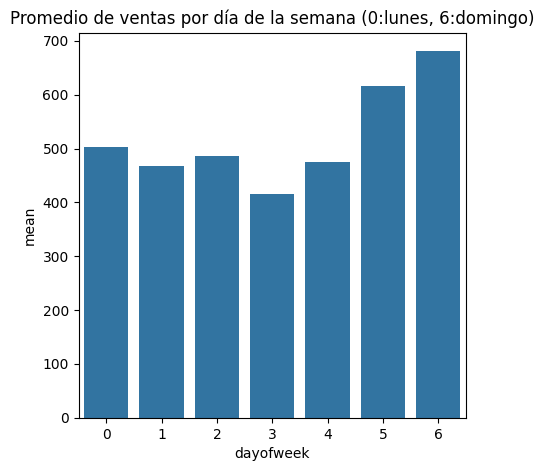

In [111]:
# por dia de la semana
dow_sales = df_sales.groupby('dayofweek')['sales'].agg(['mean', 'sum', 'count']).reset_index()

fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.barplot(x='dayofweek', y='mean', data=dow_sales, ax=ax)
ax.set_title("Promedio de ventas por día de la semana (0:lunes, 6:domingo)")

* Se puede observar que en promedio, las ventas aumentan los fines de semana.
* El día más bajo en ventas es el jueves.

Text(0.5, 1.0, 'Promedio de ventas por mes del año (1:enero, 12:diciembre)')

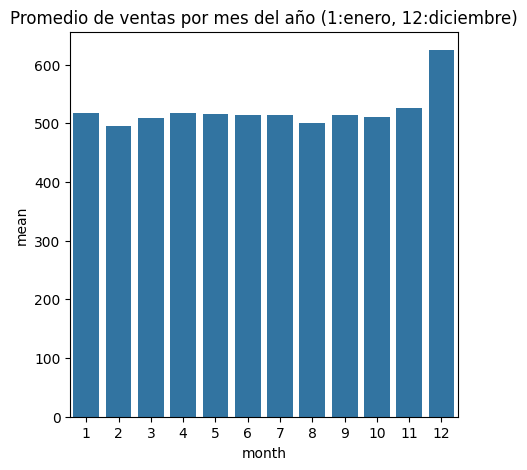

In [112]:
# por mes del año
month_sales = df_sales.groupby('month')['sales'].agg(['mean', 'sum', 'count']).reset_index()

fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.barplot(x='month', y='mean', data=month_sales, ax=ax)
ax.set_title("Promedio de ventas por mes del año (1:enero, 12:diciembre)")

* En promedio hay una clara tendencia del aumento de las ventas para Diciembre.

In [113]:
daily_sales.shape

(2061758, 24)

### Estacionariedad

Validaremos si los datos de ventas son estacionarios, es decir, que sus variables estadísticas se mantienen en el tiempo. Esto ayuda en la predicción si fuese el caso.

El método adfuller (Augmented Dickey-Fuller Test) es una prueba estadística utilizada para verificar si una serie temporal es estacionaria. La estacionariedad es una propiedad clave en el análisis de series temporales, ya que muchos modelos (como ARIMA) requieren que los datos sean estacionarios.

¿Qué es una serie estacionaria?
Una serie temporal es estacionaria si sus propiedades estadísticas, como la media, la varianza y la autocorrelación, son constantes en el tiempo. Esto significa que no hay tendencias ni estacionalidades presentes en los datos.

In [114]:
daily_sales_agg = daily_sales.groupby('date').agg({'sales': 'sum'}).reset_index()
daily_sales_agg.head()

,date,sales
0,2013-01-01,2511.618999
1,2013-01-02,496092.417944
2,2013-01-03,361461.231124
3,2013-01-04,354459.677093
4,2013-01-05,477350.121229


In [115]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_sales_agg['sales'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -2.6161957486048597
p-value: 0.08969592175787411


* Dado que p-value no es menor al rango de 0.05 (al 95% de confianza) podemos decir que la serie de ventas NO es estacionaria.
* Para verificar estacionalidad haremos una descomposición estacional y un gráfico de autocorrelación.

### Estacionalidad

Validaremos tendencias estacionales en los datos de ventas. Pueden ser anuales, mensuales y/o semanales.

In [116]:
# descomposición estacional
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_week = seasonal_decompose(daily_sales_agg['sales'], model='additive', period=7)

daily_sales_agg['sales_trend_week'] = decomposition_week.trend
daily_sales_agg['sales_seasonal_week'] = decomposition_week.seasonal
daily_sales_agg['sales_residual_week'] = decomposition_week.resid

import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=[
    "Tendencia Semanal", "Estacionalidad Semanal", "Residuo Semanal", "Ventas Diarias"
])


fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales_trend_week'],
                         mode='lines', name='Tendencia Semanal'), row=1, col=1)

# Estacionalidad Semanal
fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales_seasonal_week'],
                         mode='lines', name='Estacionalidad Semanal'), row=2, col=1)

# Residuo Semanal
fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales_residual_week'],
                         mode='lines', name='Residuo Semanal'), row=3, col=1)

# Ventas Diarias
fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales'],
                         mode='lines', name='Ventas Diarias'), row=4, col=1)

fig.update_layout(height=800, width=1000, title_text="Análisis de Ventas", showlegend=False)
fig.update_xaxes(title_text="Fecha")
# fig.update_yaxes(title_text="Ventas")
fig.show()

In [117]:
decomposition_month = seasonal_decompose(daily_sales_agg['sales'], model='additive', period=30)

daily_sales_agg['sales_trend_month'] = decomposition_month.trend
daily_sales_agg['sales_seasonal_month'] = decomposition_month.seasonal
daily_sales_agg['sales_residual_month'] = decomposition_month.resid

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, subplot_titles=[
    "Tendencia Mensual", "Estacionalidad Mensual", "Residuo Mensual", "Ventas Diarias"
])

fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales_trend_month'],
                         mode='lines', name='Tendencia Mensual'), row=1, col=1)

# Estacionalidad Mensual
fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales_seasonal_month'],
                         mode='lines', name='Estacionalidad Mensual'), row=2, col=1)

# Residuo Mensual
fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales_residual_month'],
                         mode='lines', name='Residuo Mensual'), row=3, col=1)

# Ventas Diarias
fig.add_trace(go.Scatter(x=daily_sales_agg['date'], y=daily_sales_agg['sales'],
                         mode='lines', name='Ventas Diarias'), row=4, col=1)

fig.update_layout(height=800, width=1000, title_text="Análisis de Ventas", showlegend=False)
fig.update_xaxes(title_text="Fecha")
# fig.update_yaxes(title_text="Ventas")
fig.show()

* Se observa una tendecia al aumento de las ventas durante el año.
* Podemos ver bien marcado una estacionalidad semanal y mensual.

## Correlaciones

Text(0.5, 1.0, 'Kendall Correlation')

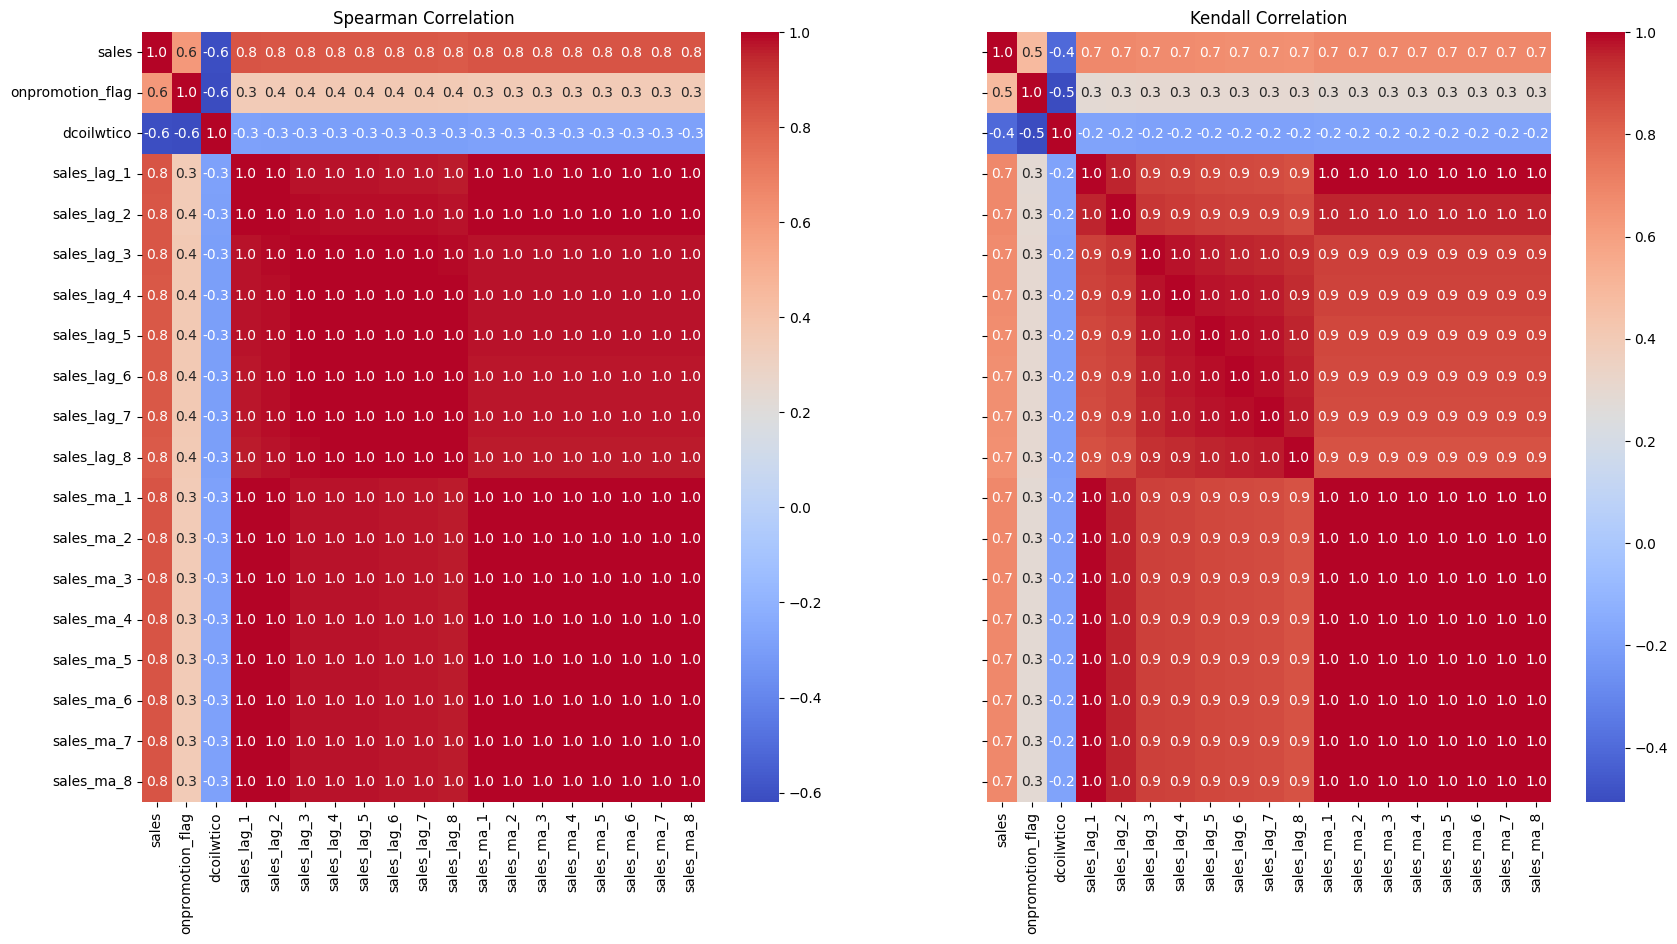

In [122]:
df_corr = daily_sales.groupby(['date']).agg({
        'sales': 'sum', 'onpromotion_flag': 'sum', 'dcoilwtico': 'mean', 
        'sales_lag_1': 'mean', 'sales_lag_2': 'mean', 'sales_lag_3': 'mean', 'sales_lag_4': 'mean', 'sales_lag_5': 'mean', 'sales_lag_6': 'mean', 'sales_lag_7': 'mean', 'sales_lag_8': 'mean',
        'sales_ma_1': 'mean', 'sales_ma_2': 'mean', 'sales_ma_3': 'mean', 'sales_ma_4': 'mean', 'sales_ma_5': 'mean', 'sales_ma_6': 'mean', 'sales_ma_7': 'mean', 'sales_ma_8': 'mean'}).reset_index()
df_corr['onpromotion_flag'] = df_corr['onpromotion_flag'].apply(lambda x: 1 if x > 0 else 0)

corr_spearman = df_corr[['sales','onpromotion_flag','dcoilwtico',
                         'sales_lag_1','sales_lag_2', 'sales_lag_3', 'sales_lag_4','sales_lag_5','sales_lag_6','sales_lag_7','sales_lag_8',
                         'sales_ma_1','sales_ma_2','sales_ma_3','sales_ma_4','sales_ma_5','sales_ma_6','sales_ma_7','sales_ma_8']].corr(method='spearman')
corr_kendall = df_corr[['sales','onpromotion_flag','dcoilwtico',
                        'sales_lag_1','sales_lag_2','sales_lag_3','sales_lag_4','sales_lag_5','sales_lag_6','sales_lag_7','sales_lag_8',
                        'sales_ma_1','sales_ma_2','sales_ma_3','sales_ma_4','sales_ma_5','sales_ma_6','sales_ma_7','sales_ma_8']].corr(method='kendall')

fig, ax = plt.subplots(1,2,figsize=(20,10), sharex=True, sharey=True)
ax = ax.flat
sns.heatmap(corr_spearman, annot=True, fmt=".1f", cmap="coolwarm", ax=ax[0])
ax[0].set_title("Spearman Correlation")

sns.heatmap(corr_kendall, annot=True, fmt=".1f", cmap="coolwarm", ax=ax[1])
ax[1].set_title("Kendall Correlation")

* Se observa una relación negativa alta entre `sales` y `dcoilwtico`. Es decir, el precio del petroleo parece ser un factor relevante para predecir las ventas.
* Respecto a las promociones, existe una relación positiva alta. Es decir, en general, cuando hay más promociones activas las ventas tienden a aumentar de manera consistente pero no necesariamente de forma lineal.
* También podemos observar una relación negativa alta entre el precio del petróleo y las promociones activas. Esto podría deberse a que el aumento en los costos reduce la capacidad de la empresa para ofrecer promociones.
* Vemos fuerte relación entre las medias moviles y las ventas previas. Esto sugiere hacer un análisis de multicolinealidad.
* En general se puede sugerir que las promociones son una herramienta importante para impulsar las ventas, pero se ven afectadas por factores externos como el precio del petróleo.

#### Factor de inflación de la varianza

El factor de inflación de la varianza (VIF) es una de las técnicas más comunes para detectar la multicolinealidad. En términos sencillos, da un valor numérico que indica cuánto se infla la varianza de un coeficiente de regresión debido a la multicolinealidad. Un valor VIF superior a 5 indica una multicolinealidad moderada, mientras que los valores superiores a 10 sugieren una multicolinealidad grave.

In [126]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X = df_corr[['onpromotion_flag','dcoilwtico',
             'sales_lag_1','sales_lag_2','sales_lag_3','sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_7', 'sales_lag_8',
             'sales_ma_1','sales_ma_2','sales_ma_3','sales_ma_4', 'sales_ma_5', 'sales_ma_6', 'sales_ma_7', 'sales_ma_8']].copy()
X_const = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data['features'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif_data.sort_values(by='VIF', ascending=True, inplace=True)

In [127]:
vif_data

,features,VIF
2,dcoilwtico,2.077375e+00
1,onpromotion_flag,2.115576e+00
0,const,6.104895e+01
10,sales_lag_8,3.554392e+02
4,sales_lag_2,5.150336e+02
9,sales_lag_7,2.346878e+03
7,sales_lag_5,4.001408e+03
5,sales_lag_3,4.645053e+03
8,sales_lag_6,5.993109e+03
3,sales_lag_1,1.298609e+04


* Valores de VIF cercanos a 1 indican que no hay correlación entre esa variable y las demás.
* VIF entre 1 y 5 indican correlación moderada.
    * `dcoilwtico`
    * `onpromotion_flag`
* VIF mayores a 5 se considera multicolinealidad alta. Estas variables pueden ser redundantes.

## Modeling

In [128]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

def smape(y_true, y_pred):
    """Symmetric MAPE: menos sensible a valores bajos de ventas"""
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    mask = denominator != 0
    return (np.mean(np.abs(y_true[mask] - y_pred[mask]) / denominator[mask])) * 100

def calc_metrics(y_true, y_pred, name="Model"):
    # se filtran ventas = 0 para MAPE
    mask = y_true != 0
    y_true_nonzero = y_true[mask]
    y_pred_nonzero = y_pred[mask]

    # Métricas
    mape = mean_absolute_percentage_error(y_true_nonzero, y_pred_nonzero) * 100
    smape_val = smape(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)

    # Reporte
    print(f"{name}")
    print(f"MAPE : {mape:.2f}%")
    print(f"sMAPE: {smape_val:.2f}%")
    print(f"RMSE : {rmse:,.0f}")
    print(f"MAE  : {mae:,.0f}\n")

* Construiremos `sales_naive` como proxy para representar un modelo simple que asume que las ventas de un periodo son iguales a las del periodo anterior.

* Para el entrenamiento, utilizaremos como test las últimas 26 semanas del último año.

In [129]:
_max_year = daily_sales['date'].dt.year.max()
_max_week = 26
test_date = daily_sales[(daily_sales['date'].dt.year == _max_year) & (daily_sales['date'].dt.isocalendar().week <= _max_week)]['date'].min()
test_date = pd.to_datetime(test_date)
print(test_date)

2017-01-02 00:00:00


### Naive Forecast (baseline)

In [130]:
daily_sales['sales_naive'] = daily_sales.groupby('store_nbr')['sales'].shift(1)
daily_sales.fillna({'sales_naive': 0}, inplace=True)

naive_sales = daily_sales.groupby('date').agg({'sales':'sum', 'sales_naive': 'sum'}).reset_index()

In [131]:
train = naive_sales[naive_sales['date'] < test_date].copy()
test = naive_sales[~(naive_sales['date'] >= test_date)].copy()

In [132]:
calc_metrics(test['sales'], test['sales_naive'], name="Naive Model")

Naive Model
MAPE : 0.14%
sMAPE: 0.14%
RMSE : 1,496
MAE  : 886



### Regresion Lineal

In [153]:
import statsmodels.api as sm

df_linreg = daily_sales.groupby(['date']).agg({'sales': 'sum', 'onpromotion_flag': 'sum', 'dcoilwtico': 'mean', 
                                               'sales_lag_1': 'mean', 'sales_lag_2': 'mean', 'sales_lag_3': 'mean', 'sales_lag_4': 'mean', 'sales_lag_5': 'mean', 'sales_lag_6': 'mean', 'sales_lag_7': 'mean', 'sales_lag_8': 'mean', 
                                               'sales_ma_1': 'mean', 'sales_ma_2': 'mean', 'sales_ma_3': 'mean', 'sales_ma_4': 'mean', 'sales_ma_5': 'mean', 'sales_ma_6': 'mean', 'sales_ma_7': 'mean', 'sales_ma_8': 'mean'}).reset_index()
df_linreg['onpromotion_flag'] = df_linreg['onpromotion_flag'].apply(lambda x: 1 if x > 0 else 0)

# features = ['onpromotion_flag', 'dcoilwtico']
# features = ['onpromotion_flag', 'dcoilwtico', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_7', 'sales_lag_8', 'sales_ma_1', 'sales_ma_2', 'sales_ma_3', 'sales_ma_4', 'sales_ma_5', 'sales_ma_6', 'sales_ma_7', 'sales_ma_8']
features = ['onpromotion_flag', 'dcoilwtico', 
            'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_8', 'sales_ma_1']

train = df_linreg[df_linreg['date'] < test_date].copy()
test = df_linreg[~(df_linreg['date'] >= test_date)].copy()

X = sm.add_constant(train[features])
y = train['sales']

X_test = sm.add_constant(test[features])
y_test = test['sales']

linreg = sm.OLS(y, X)
result = linreg.fit()

y_pred = result.predict(X_test)

calc_metrics(y_test, y_pred, name="Linear Regression (SM)")

print(result.summary())

Linear Regression (SM)
MAPE : 16.18%
sMAPE: 10.84%
RMSE : 78,440
MAE  : 58,792

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1149.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:07:52   Log-Likelihood:                -18501.
No. Observations:                1458   AIC:                         3.702e+04
Df Residuals:                    1448   BIC:                         3.707e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------

* Interpretación de métricas

    * MAPE (16.18%): Esto significa que, en promedio, las predicciones se desvían un 16% del valor real de las ventas.
    
    * sMAPE (10.84%): Es la versión simétrica del MAPE, menos sensible a valores extremos. 
        * Buen resultado, más “conservador” que el MAPE.

    * RMSE (78,440): Raíz del error cuadrático medio. Mide la desviación estándar de los errores en unidades de ventas.
        * Las predicciones, en promedio, se desvían unos 78K unidades de ventas respecto a lo real. Las ventas diarias son del orden de cientos de miles, es un error grande pero no desproporcionado.

    * MAE (58,792): Error absoluto medio. Las predicciones se equivocan, en promedio, por 58.6K unidades de ventas al día.
        * Siempre es más “optimista” que el RMSE porque no penaliza tanto los errores grandes.

    * R-squared (0.877): El modelo explica un 87.7% de la variabilidad en las ventas usando las variables elegidas.
        * Esto es bastante bueno, indica que los predictores elegidos (promociones, petróleo, lags, medias móviles) capturan muy bien el comportamiento.

* Coeficientes
    * const (108,900): Ventas promedio cuando todas las demás variables están en cero. Representa la base de ventas.

    * onpromotion_flag (33,140): Cuando hay promociones activas en un día, las ventas suben en promedio en +33K unidades.
        * Promoción = factor positivo claro y fuerte.

    * dcoilwtico (-3,051): El precio internacional del petróleo (WTI) tiene un impacto negativo en las ventas: por cada punto que sube, las ventas bajan en promedio 3K unidades.
        * Hace sentido en Ecuador, donde la economía depende del petróleo: más caro el petróleo, menor poder de consumo.

    * sales_lag_2 (-2,745): Un efecto negativo de las ventas de hace 2 días: si esas fueron altas, hoy las ventas tienden a bajar en 2.7K unidades.
        * Podría reflejar patrones de “compra adelantada” o estacionalidad corta.
    
    * sales_lag_3 (−6,914): Fuerte efecto negativo a 3 días. Caída sistemática después de picos.

    * sales_lag_4 (+8,435): Rebote positivo al cuarto día. Patrón cíclico.

    * sales_lag_5 (+4,532): También positivo, aunque más moderado.

    * sales_lag_6 (−6,790): Caída significativa al sexto día.

    * sales_lag_8 (+777): Efecto positivo leve a la semana y un día.

    * sales_ma_1 (+4,075): La media móvil de un día tiene efecto positivo: ventas recientes influyen en que hoy se vendan unas +4K unidades adicionales.
        * Capta inercia: si ayer vendiste mucho, hoy también se espera vender más.

In [154]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features = ['onpromotion_flag', 'dcoilwtico', 
            'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_8', 'sales_ma_1']

# df_linreg = daily_sales.groupby(['date']).agg({'sales': 'sum', 'onpromotion_flag': 'sum', 'dcoilwtico': 'mean', 'sales_lag_1': 'mean', 'sales_lag_2': 'mean', 'sales_lag_4': 'mean', 'sales_ma_1': 'mean', 'sales_ma_2': 'mean', 'sales_ma_3': 'mean', 'sales_ma_4': 'mean'}).reset_index()
# df_linreg['onpromotion_flag'] = df_linreg['onpromotion_flag'].apply(lambda x: 1 if x > 0 else 0)

# train = df_linreg[df_linreg['date'] < test_date].copy()
# test = df_linreg[df_linreg['date'] >= test_date].copy()

# scaler = StandardScaler()
scaler = MinMaxScaler()

X = sm.add_constant(scaler.fit_transform(train[features]))
y = train['sales']

X_test = sm.add_constant(scaler.transform(test[features]))
y_test = test['sales']

linreg = sm.OLS(y, X)
result = linreg.fit()

y_pred = result.predict(X_test)

calc_metrics(y_test, y_pred, name="Linear Regression (SM)")

print(result.summary())

Linear Regression (SM)
MAPE : 16.18%
sMAPE: 10.84%
RMSE : 78,440
MAE  : 58,792

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1149.
Date:                Thu, 04 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:08:02   Log-Likelihood:                -18501.
No. Observations:                1458   AIC:                         3.702e+04
Df Residuals:                    1448   BIC:                         3.707e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

In [162]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pandas as pd

features = ['onpromotion_flag', 'dcoilwtico', 
            'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 
            'sales_lag_5', 'sales_lag_6', 'sales_lag_8', 'sales_ma_1']

X_train, y_train = train[features], train['sales']
X_test, y_test   = test[features], test['sales']

param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 500, 1000]}

models = {
    "Ridge": Ridge(max_iter=5000),
    "Lasso": Lasso(max_iter=5000),
    "ElasticNet": ElasticNet(max_iter=5000, l1_ratio=0.5)  # l1_ratio mezcla L1/L2
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # mejor modelo
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    
    # metricas
    results[name] = {
        "best_alpha": grid.best_params_['model__alpha'],
        "metrics": calc_metrics(y_test, y_pred, name=f"{name} (best α={grid.best_params_['model__alpha']})"),
        "coef": pd.Series(best_model.named_steps['model'].coef_, index=features)
    }

# results
for name, res in results.items():
    print(f"\n{name} Results:")
    print(f"Best alpha: {res['best_alpha']}")
    print("Coefficients:")
    print(res["coef"])

Ridge (best α=0.01)
MAPE : 16.31%
sMAPE: 10.84%
RMSE : 78,449
MAE  : 58,759



/Users/hugopriest/anaconda3/envs/dev_carozzi/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.213e+12, tolerance: 5.104e+09
  model = cd_fast.enet_coordinate_descent(
/Users/hugopriest/anaconda3/envs/dev_carozzi/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.214e+12, tolerance: 5.104e+09
  model = cd_fast.enet_coordinate_descent(
/Users/hugopriest/anaconda3/envs/dev_carozzi/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

Lasso (best α=0.001)
MAPE : 16.68%
sMAPE: 10.82%
RMSE : 78,689
MAE  : 58,793

ElasticNet (best α=0.001)
MAPE : 18.02%
sMAPE: 10.81%
RMSE : 79,478
MAE  : 59,050


Ridge Results:
Best alpha: 0.01
Coefficients:
onpromotion_flag     15420.240277
dcoilwtico          -80675.399709
sales_lag_2        -313145.294672
sales_lag_3        -729065.104124
sales_lag_4         853752.541965
sales_lag_5         500933.658741
sales_lag_6        -722630.854668
sales_lag_8          90844.984206
sales_ma_1          478539.795059
dtype: float64

Lasso Results:
Best alpha: 0.001
Coefficients:
onpromotion_flag     15742.314255
dcoilwtico          -80844.756518
sales_lag_2        -280288.166756
sales_lag_3        -448699.705853
sales_lag_4         514919.404047
sales_lag_5         314668.174749
sales_lag_6        -508110.625682
sales_lag_8         115977.641029
sales_ma_1          450811.386153
dtype: float64

ElasticNet Results:
Best alpha: 0.001
Coefficients:
onpromotion_flag     16324.836662
dcoilwtico     

/Users/hugopriest/anaconda3/envs/dev_carozzi/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.890e+12, tolerance: 4.980e+09
  model = cd_fast.enet_coordinate_descent(
/Users/hugopriest/anaconda3/envs/dev_carozzi/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.696e+12, tolerance: 7.302e+09



### ETS: Error-Trend-Seasonality

In [163]:
ets_sales = daily_sales_agg[['date','sales']].set_index('date')
ets_sales.sort_index(inplace=True)
ets_sales = ets_sales.asfreq('D')
ets_sales.fillna({'sales': 0}, inplace=True)
ets_sales.head()

,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


https://medium.com/@atharva.chouthai/choosing-the-right-time-series-model-part-2-classical-time-series-methods-83c01a2ed6c3

Holt-Winters Model
MAPE : 30.34%
sMAPE: 18.09%
RMSE : 188,786
MAE  : 148,806



<Axes: xlabel='date', ylabel='sales'>

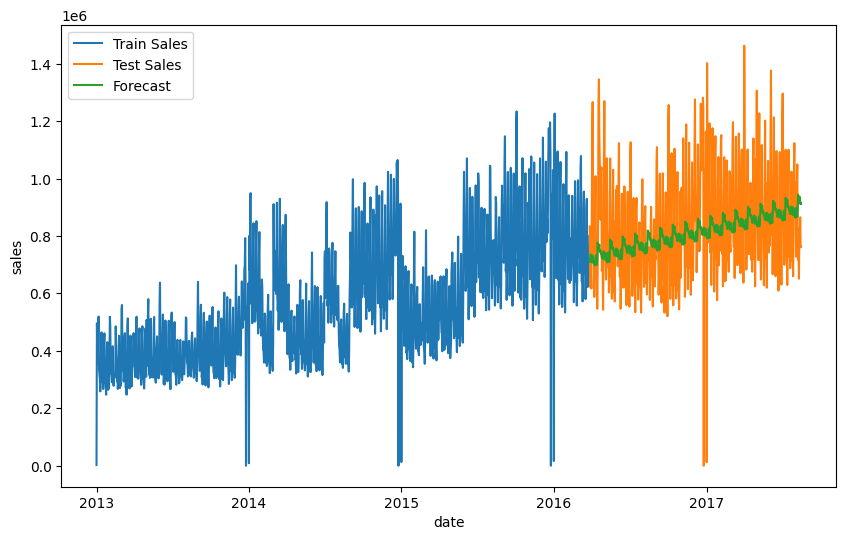

In [164]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# uso el 70% para entrenamiento
train_size = int(len(ets_sales) * 0.7)
train, test = ets_sales.iloc[:train_size], ets_sales.iloc[train_size:]

model = ExponentialSmoothing(train['sales'], trend='add', seasonal='add', seasonal_periods=30)
fitted_model = model.fit()

forecast = fitted_model.forecast(steps=len(ets_sales) - train_size)

calc_metrics(test['sales'], forecast, name="Holt-Winters Model")

fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=train['sales'], ax=ax, label='Train Sales')
sns.lineplot(data=test['sales'], ax=ax, label='Test Sales')
sns.lineplot(data=forecast, ax=ax, label='Forecast')

In [168]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

df_sarimax = df_linreg.copy()

features = ['onpromotion_flag', 'dcoilwtico', 
            'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 
            'sales_lag_5', 'sales_lag_6', 'sales_lag_8', 'sales_ma_1']

X = df_sarimax[features].copy()
y = df_sarimax['sales'].copy()

X_train = X[df_sarimax['date'] < test_date].copy()
X_test = X[df_sarimax['date'] >= test_date].copy()

y_train = y[df_sarimax['date'] < test_date].copy()
y_test = y[df_sarimax['date'] >= test_date].copy()

p = d = q = range(0, 2)
P = D = Q = range(0, 2)
m = [7] # estacionalidad semanal

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m[0]) for x in itertools.product(P, D, Q)]

best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# grid search
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(
                y_train,
                exog=X_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
        except:
            continue

print(f"Mejor modelo SARIMAX: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")

y_pred = best_model.predict(
    start=y_test.index[0], 
    end=y_test.index[-1], 
    exog=X_test
)

Mejor modelo SARIMAX: order=(1, 0, 1), seasonal_order=(1, 1, 1, 7), AIC=34453.14


In [169]:
calc_metrics(y_test, y_pred, name="SARIMAX Model")

SARIMAX Model
MAPE : 8.45%
sMAPE: 9.02%
RMSE : 96,190
MAE  : 75,715



### Machine Learning

#### Prophet

Utilizaremos Prophet (Meta) por lo siguiente:

* Descomposición automática: separa la serie en tendencia, estacionalidad (semanal, mensual) y efecto de feriados/eventos.
* Manejo de estacionalidades múltiples: útil en ventas de supermercados que suelen tener ciclos semanales y anuales.
* Robusto a outliers: aguanta valores extremos sin que distorsionen la predicción.
* Exógenas (regresores adicionales): se pueden incorporar variables como `onpromotion_flag` o `dcoilwtico`.
* Predicciones con intervalos de confianza: muy útil para dar visibilidad al negocio.

In [174]:
from prophet import Prophet

df_prophet = df_linreg[['date', 'sales', 'onpromotion_flag', 'dcoilwtico',
                        'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_8', 'sales_ma_1']].copy()
df_prophet.rename(columns={'date': 'ds', 'sales': 'y'}, inplace=True)

# genero un df con los feriados de Ecuador
ecuador_holidays = par.get_holidays(df_prophet['ds'].dt.year.min(), df_prophet['ds'].dt.year.max())

train_prophet = df_prophet[df_prophet['ds'] < test_date].copy()
test_prophet = df_prophet[df_prophet['ds'] >= test_date].copy()

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=ecuador_holidays,
    interval_width=0.95
)

model.add_regressor('onpromotion_flag')
model.add_regressor('dcoilwtico')
model.add_regressor('sales_lag_2')
model.add_regressor('sales_lag_3')
model.add_regressor('sales_lag_4')
model.add_regressor('sales_lag_5')
model.add_regressor('sales_lag_6')
model.add_regressor('sales_lag_8')
model.add_regressor('sales_ma_1')

model.fit(train_prophet)

future = df_prophet[['ds', 'onpromotion_flag', 'dcoilwtico', 'sales_lag_2', 'sales_lag_3', 'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_8', 'sales_ma_1']].copy()

forecast = model.predict(future)

y_pred = forecast.loc[forecast['ds'] >= test_date, 'yhat'].values
y_true = test_prophet['y'].values

23:36:10 - cmdstanpy - INFO - Chain [1] start processing
23:36:10 - cmdstanpy - INFO - Chain [1] done processing


In [178]:
# model.plot(forecast)

In [179]:
# model.plot_components(forecast)

In [177]:
calc_metrics(y_true, y_pred, name="Prophet Model")

Prophet Model
MAPE : 6.99%
sMAPE: 7.31%
RMSE : 73,643
MAE  : 62,651



### Resultados preliminares

Finalmente obtenemos lo siguiente:

|Modelo|MAPE (%)|sMAPE (%)|RMSE|MAE|
|---|---|---|---|---|
|Linear Reg. (mejor subset)|16.18|10.84|78,440|58,792|
|Ridge|18.25|10.80|79,624|59,090|
|Lasso|17.42|10.87|79,470|59,269|
|SARIMAX|8.45|9.02|96,190|75,715|
|Prophet|6.99|7.31|73,643|62,651|

* MAPE / sMAPE: SARIMAX logra menos de la mitad del error relativo (8.45% vs ~16–18%) en comparación con las regresiones. Sin embargo el mejor resultado es con Prophet (~7%). Esto es muy fuerte: el modelo está mucho más alineado con la dinámica real de las ventas.

* RMSE y MAE: Aquí las regresiones lineales salen mejor (78k vs 96k en RMSE, 58k vs 75k en MAE). Esto puede deberse a que:
    * Las regresiones ajustan bien valores absolutos con lags y medias móviles.
    * SARIMAX está capturando mejor la tendencia y estacionalidad (reflejado en el MAPE bajo), pero puede quedarse corto en magnitudes absolutas en ciertos picos de ventas. 
    * Sin embargo las predicciones de Prophet siguen siendo más escalables.

#### Conclusiones

* Dado el objetivo de predecir las ventas en un rango de 26 semanas, utilizaremos Prophet dado todo lo anterior.